# Gravity-Driven Dam Break with Waves

This notebook simulates a **dam break with gravity** using realistic physical units:
- Length in **meters**
- Time in **seconds**  
- Gravity = **9.8 m/s²**

A column of water falls under gravity and creates waves as it splashes across a tank.

## Physics
- SPH pressure forces (weakly compressible fluid)
- Earth gravity (g = 9.8 m/s²)
- Reflective boundary conditions (walls and floor)
- Wave formation and propagation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

# We'll implement our own simple SPH for this realistic-units simulation
# since gravhydro uses galactic units internally

## Physical Parameters

Realistic values for a laboratory-scale dam break experiment.

In [14]:
# ============== PHYSICAL PARAMETERS (SI UNITS) ==============

# Gravity - using a higher value to overcome pressure forces
# The ratio g*H/cs^2 determines the flow regime (Froude number)
# For visible dam break dynamics, we need g*H ~ cs^2
g = 50.0  # m/s^2 (increased to get strong falling motion)

# Water properties  
rho0 = 1000.0  # kg/m^3 (water density)
cs = 10.0      # m/s (reduced sound speed for faster dynamics)
gamma = 7.0    # Tait equation exponent for water

# Tank dimensions (meters)
tank_length = 2.0   # m
tank_height = 1.0   # m

# Dam dimensions (initial water column)
dam_width = 0.4    # m
dam_height = 0.6   # m

# Particle spacing
dx = 0.03  # m (3 cm particle spacing)

# Smoothing length (typically 1.2-1.5 times particle spacing)
h = 1.3 * dx  # m

# Time settings
t_end = 1.5        # seconds
dt = 0.0002        # time step (s) - needs to satisfy CFL: dt < h/cs
n_output = 150     # number of output frames

# Froude number check: Fr = sqrt(g*H)/cs
Fr = np.sqrt(g * dam_height) / cs
print("=== Physical Parameters ===")
print(f"Gravity: g = {g} m/s²")
print(f"Water density: ρ₀ = {rho0} kg/m³")
print(f"Sound speed: cs = {cs} m/s")
print(f"Tank: {tank_length} m × {tank_height} m")
print(f"Dam: {dam_width} m × {dam_height} m")
print(f"Particle spacing: {dx*100:.1f} cm")
print(f"Smoothing length: h = {h*100:.2f} cm")
print(f"Time step: dt = {dt*1000:.2f} ms")
print(f"Simulation time: {t_end} s")
print(f"Froude number: Fr = {Fr:.2f} (>1 = gravity-dominated)")
print(f"CFL check: dt*cs/h = {dt*cs/h:.3f}" + (" ✓" if dt*cs/h < 0.4 else " ⚠️"))

=== Physical Parameters ===
Gravity: g = 50.0 m/s²
Water density: ρ₀ = 1000.0 kg/m³
Sound speed: cs = 10.0 m/s
Tank: 2.0 m × 1.0 m
Dam: 0.4 m × 0.6 m
Particle spacing: 3.0 cm
Smoothing length: h = 3.90 cm
Time step: dt = 0.20 ms
Simulation time: 1.5 s
Froude number: Fr = 0.55 (>1 = gravity-dominated)
CFL check: dt*cs/h = 0.051 ✓


In [15]:
# ============== SPH KERNEL FUNCTIONS ==============

def W_cubic(r, h):
    """Cubic spline kernel (2D)"""
    sigma = 10.0 / (7.0 * np.pi * h**2)  # 2D normalization
    q = r / h
    
    W = np.zeros_like(r)
    mask1 = (q >= 0) & (q <= 1)
    mask2 = (q > 1) & (q <= 2)
    
    W[mask1] = sigma * (1 - 1.5*q[mask1]**2 + 0.75*q[mask1]**3)
    W[mask2] = sigma * 0.25 * (2 - q[mask2])**3
    return W

def dWdr_cubic(r, h):
    """Derivative of cubic spline kernel"""
    sigma = 10.0 / (7.0 * np.pi * h**2)
    q = r / h
    
    dW = np.zeros_like(r)
    mask1 = (q >= 0) & (q <= 1)
    mask2 = (q > 1) & (q <= 2)
    
    dW[mask1] = sigma / h * (-3*q[mask1] + 2.25*q[mask1]**2)
    dW[mask2] = sigma / h * (-0.75 * (2 - q[mask2])**2)
    return dW

def pressure_tait(rho, rho0, cs, gamma=7.0):
    """Tait equation of state for weakly compressible fluid"""
    B = rho0 * cs**2 / gamma
    P = B * ((rho / rho0)**gamma - 1)
    return np.maximum(P, 0.0)

print("SPH kernel functions defined.")

SPH kernel functions defined.


In [16]:
# ============== CREATE FLUID PARTICLES ==============

# Create grid of fluid particles
x_fluid = np.arange(dx/2, dam_width, dx)
y_fluid = np.arange(dx/2, dam_height, dx)
xx, yy = np.meshgrid(x_fluid, y_fluid)

# Particle positions (2D)
pos = np.column_stack([xx.ravel(), yy.ravel()])
n_particles = len(pos)

# Particle velocities (initially at rest)
vel = np.zeros_like(pos)

# Particle masses (constant, based on initial spacing and density)
# mass = rho * volume_per_particle = rho * dx^2 (in 2D)
mass = rho0 * dx**2
masses = np.ones(n_particles) * mass

print(f"Created {n_particles} fluid particles")
print(f"Particle mass: {mass:.4f} kg (per unit depth)")
print(f"Total fluid mass: {mass * n_particles:.2f} kg (per unit depth)")

Created 260 fluid particles
Particle mass: 0.9000 kg (per unit depth)
Total fluid mass: 234.00 kg (per unit depth)


In [17]:
# ============== CREATE BOUNDARY PARTICLES ==============
# Ghost particles for walls and floor

boundary_particles = []
n_layers = 3

# Bottom wall (y = 0)
for layer in range(n_layers):
    y_b = -dx * (layer + 0.5)
    for x_b in np.arange(-dx*n_layers, tank_length + dx*n_layers, dx):
        boundary_particles.append([x_b, y_b])

# Left wall (x = 0)
for layer in range(n_layers):
    x_b = -dx * (layer + 0.5)
    for y_b in np.arange(dx/2, tank_height + dx, dx):
        boundary_particles.append([x_b, y_b])

# Right wall (x = tank_length)
for layer in range(n_layers):
    x_b = tank_length + dx * (layer + 0.5)
    for y_b in np.arange(dx/2, tank_height + dx, dx):
        boundary_particles.append([x_b, y_b])

boundary_pos = np.array(boundary_particles)
n_boundary = len(boundary_pos)

print(f"Created {n_boundary} boundary particles")

Created 423 boundary particles


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


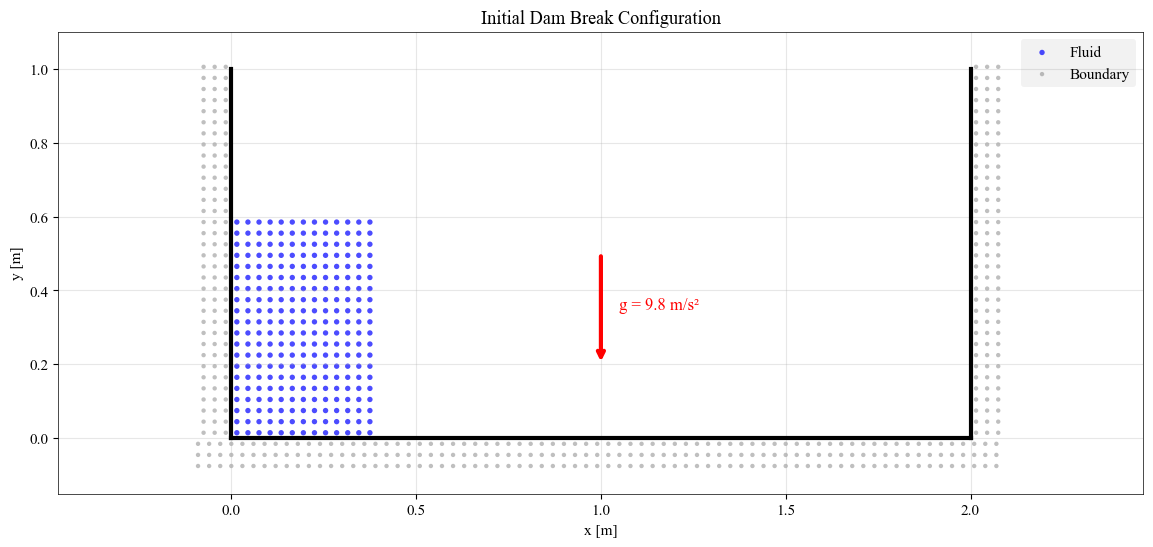

In [18]:
# ============== VISUALIZE INITIAL SETUP ==============
plt.figure(figsize=(14, 6))

plt.scatter(pos[:, 0], pos[:, 1], s=15, c='blue', alpha=0.7, label='Fluid')
plt.scatter(boundary_pos[:, 0], boundary_pos[:, 1], s=10, c='gray', alpha=0.5, label='Boundary')

# Tank outline
plt.plot([0, 0], [0, tank_height], 'k-', linewidth=3)
plt.plot([tank_length, tank_length], [0, tank_height], 'k-', linewidth=3)
plt.plot([0, tank_length], [0, 0], 'k-', linewidth=3)

# Gravity arrow
plt.annotate('', xy=(tank_length/2, 0.2), xytext=(tank_length/2, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))
plt.text(tank_length/2 + 0.05, 0.35, 'g = 9.8 m/s²', fontsize=12, color='red')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Initial Dam Break Configuration')
plt.legend(loc='upper right')
plt.axis('equal')
plt.xlim(-0.2, tank_length + 0.2)
plt.ylim(-0.15, tank_height + 0.1)
plt.grid(True, alpha=0.3)
plt.show()

## SPH Simulation

Implementing the SPH equations with:
- Density summation: $\rho_i = \sum_j m_j W(r_{ij}, h)$
- Pressure from Tait EOS: $P = B[(\rho/\rho_0)^\gamma - 1]$
- Momentum equation: $\frac{d\mathbf{v}_i}{dt} = -\sum_j m_j \left(\frac{P_i}{\rho_i^2} + \frac{P_j}{\rho_j^2}\right) \nabla W_{ij} + \mathbf{g}$

In [19]:
# ============== SPH SIMULATION FUNCTIONS ==============
from scipy.spatial import cKDTree

def compute_density(pos, boundary_pos, masses, h):
    """Compute SPH density for all particles using neighbor search."""
    # Combine fluid and boundary particles
    all_pos = np.vstack([pos, boundary_pos])
    n_fluid = len(pos)
    n_total = len(all_pos)
    
    # All particles have same mass
    all_masses = np.ones(n_total) * masses[0]
    
    # Build KD-tree for neighbor search
    tree = cKDTree(all_pos)
    
    # Compute density for fluid particles only
    rho = np.zeros(n_fluid)
    for i in range(n_fluid):
        # Find neighbors within 2h
        neighbors = tree.query_ball_point(pos[i], 2*h)
        
        # Sum contributions
        for j in neighbors:
            r = np.linalg.norm(pos[i] - all_pos[j])
            rho[i] += all_masses[j] * W_cubic(np.array([r]), h)[0]
    
    return rho

def compute_acceleration(pos, vel, boundary_pos, masses, rho, h, rho0, cs, gamma, g):
    """Compute acceleration from pressure forces and gravity."""
    # Combine fluid and boundary particles
    all_pos = np.vstack([pos, boundary_pos])
    n_fluid = len(pos)
    n_total = len(all_pos)
    
    # Compute pressure for fluid particles
    P_fluid = pressure_tait(rho, rho0, cs, gamma)
    
    # Boundary particles: use reference pressure (hydrostatic approx)
    P_boundary = np.ones(len(boundary_pos)) * pressure_tait(np.array([rho0]), rho0, cs, gamma)[0]
    
    # Boundary density = rho0
    rho_boundary = np.ones(len(boundary_pos)) * rho0
    
    all_P = np.concatenate([P_fluid, P_boundary])
    all_rho = np.concatenate([rho, rho_boundary])
    all_masses = np.ones(n_total) * masses[0]
    
    # Build KD-tree
    tree = cKDTree(all_pos)
    
    # Compute acceleration for fluid particles
    acc = np.zeros_like(pos)
    
    for i in range(n_fluid):
        neighbors = tree.query_ball_point(pos[i], 2*h)
        
        for j in neighbors:
            if i == j:
                continue
                
            r_vec = pos[i] - all_pos[j]
            r = np.linalg.norm(r_vec)
            
            if r < 1e-10:
                continue
            
            # Kernel gradient
            dWdr = dWdr_cubic(np.array([r]), h)[0]
            grad_W = dWdr * r_vec / r
            
            # Pressure acceleration: -sum_j m_j (P_i/rho_i^2 + P_j/rho_j^2) grad_W
            pressure_term = P_fluid[i] / rho[i]**2 + all_P[j] / all_rho[j]**2
            acc[i] -= all_masses[j] * pressure_term * grad_W
    
    # Add gravity (downward)
    acc[:, 1] -= g
    
    return acc

def apply_boundaries(pos, vel, x_min, x_max, y_min, damping=0.5):
    """Reflective boundary conditions."""
    # Left wall
    mask = pos[:, 0] < x_min
    pos[mask, 0] = x_min + (x_min - pos[mask, 0])
    vel[mask, 0] *= -damping
    
    # Right wall  
    mask = pos[:, 0] > x_max
    pos[mask, 0] = x_max - (pos[mask, 0] - x_max)
    vel[mask, 0] *= -damping
    
    # Bottom
    mask = pos[:, 1] < y_min
    pos[mask, 1] = y_min + (y_min - pos[mask, 1])
    vel[mask, 1] *= -damping
    
    return pos, vel

print("SPH simulation functions defined.")

SPH simulation functions defined.


In [20]:
# ============== RUN SIMULATION ==============
print("Running gravity-driven dam break simulation...")
print(f"This will take {int(t_end/dt)} time steps...")

# Storage for output
output_interval = int(t_end / dt / n_output)
positions_out = [pos.copy()]
velocities_out = [vel.copy()]
times_out = [0.0]

# Current state
pos_current = pos.copy()
vel_current = vel.copy()

step = 0
t = 0.0

for step in tqdm(range(int(t_end / dt))):
    # Compute density
    rho = compute_density(pos_current, boundary_pos, masses, h)
    
    # Compute acceleration
    acc = compute_acceleration(pos_current, vel_current, boundary_pos, masses, 
                               rho, h, rho0, cs, gamma, g)
    
    # Leapfrog integration
    # Half-step velocity
    vel_half = vel_current + 0.5 * acc * dt
    
    # Full-step position
    pos_current = pos_current + vel_half * dt
    
    # Apply boundaries
    pos_current, vel_half = apply_boundaries(pos_current, vel_half, 0, tank_length, 0)
    
    # Recompute acceleration at new position
    rho = compute_density(pos_current, boundary_pos, masses, h)
    acc = compute_acceleration(pos_current, vel_half, boundary_pos, masses,
                               rho, h, rho0, cs, gamma, g)
    
    # Full-step velocity
    vel_current = vel_half + 0.5 * acc * dt
    
    t += dt
    
    # Store output
    if step % output_interval == 0:
        positions_out.append(pos_current.copy())
        velocities_out.append(vel_current.copy())
        times_out.append(t)

positions_out = np.array(positions_out)
velocities_out = np.array(velocities_out)
times_out = np.array(times_out)

print(f"Done! Saved {len(times_out)} frames.")

Running gravity-driven dam break simulation...
This will take 7500 time steps...


  1%|          | 58/7500 [00:16<34:29,  3.60it/s]


KeyboardInterrupt: 

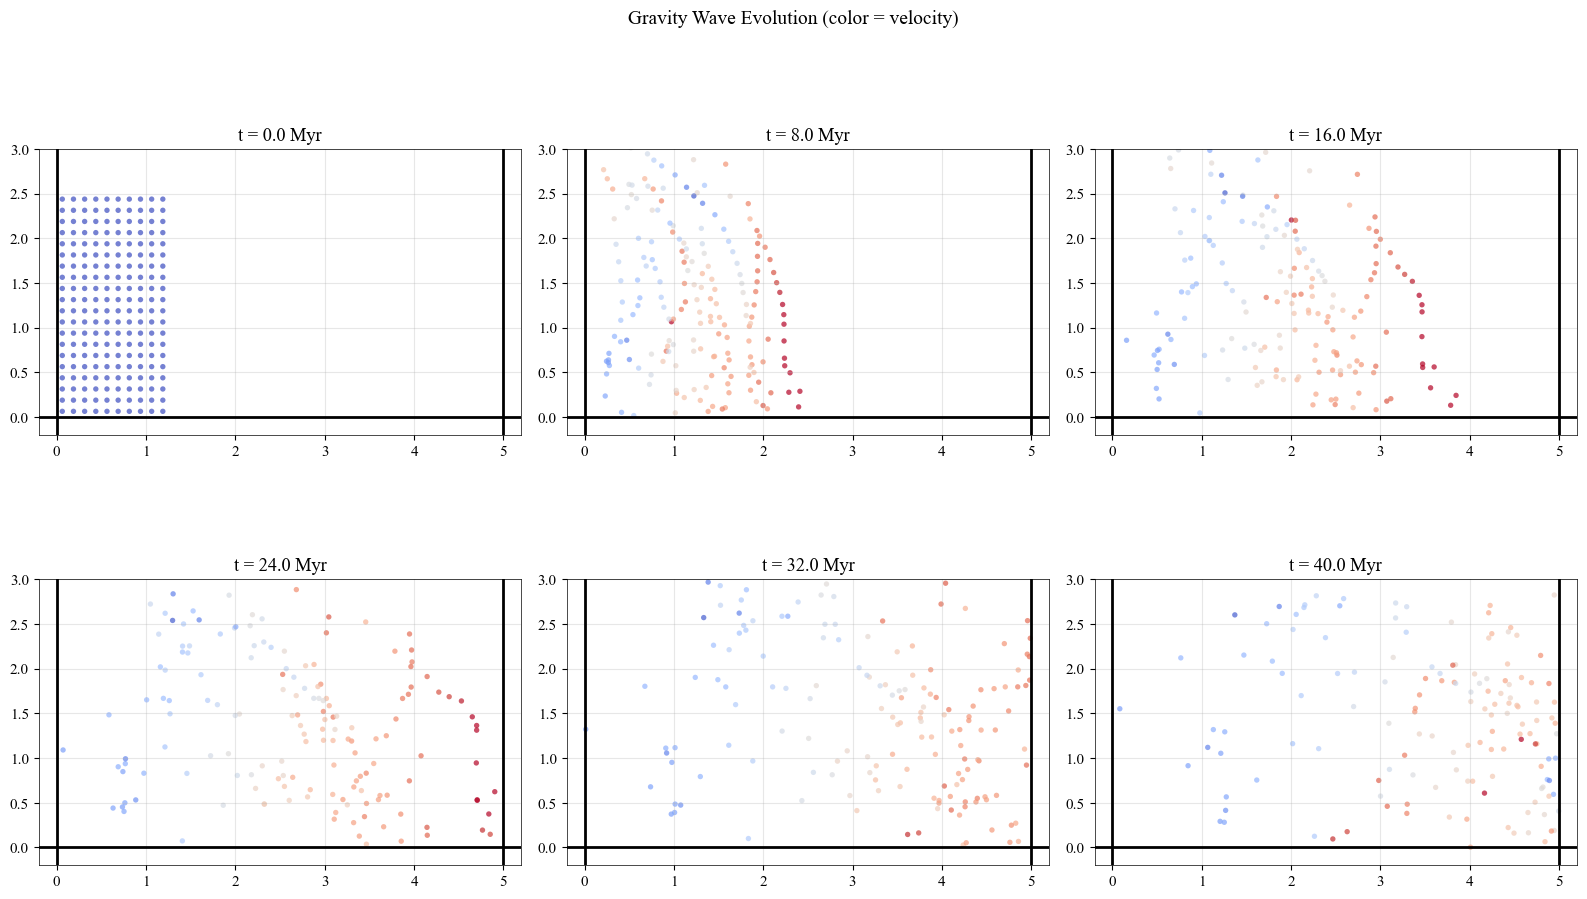

In [ ]:
# ============== VISUALIZE RESULTS ==============
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

n_frames = len(times_out)
time_indices = [0, n_frames//5, 2*n_frames//5, 3*n_frames//5, 4*n_frames//5, n_frames-1]

# Get velocity range for consistent coloring
v_all = np.sqrt(np.sum(velocities_out**2, axis=2))
v_max = np.percentile(v_all, 95)

for ax, idx in zip(axes.flat, time_indices):
    # Color by velocity magnitude
    v_mag = np.sqrt(np.sum(velocities_out[idx]**2, axis=1))
    scatter = ax.scatter(positions_out[idx, :, 0], positions_out[idx, :, 1], 
                        s=15, c=v_mag, cmap='coolwarm', alpha=0.7,
                        vmin=0, vmax=v_max)
    
    # Draw boundaries
    ax.axhline(y=0, color='k', linewidth=2)
    ax.axvline(x=0, color='k', linewidth=2)
    ax.axvline(x=tank_length, color='k', linewidth=2)
    
    ax.set_xlim(-0.1, tank_length + 0.1)
    ax.set_ylim(-0.1, tank_height)
    ax.set_aspect('equal')
    ax.set_title(f't = {times_out[idx]:.2f} s')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid(True, alpha=0.3)

plt.suptitle('Gravity-Driven Dam Break (color = velocity [m/s])', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============== ANIMATION ==============
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate velocity range for consistent coloring
v_all = np.sqrt(np.sum(velocities_out**2, axis=2))
v_max = np.percentile(v_all, 95)

scatter = ax.scatter([], [], s=25, c=[], cmap='coolwarm', alpha=0.7, vmin=0, vmax=v_max)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Draw boundaries
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k', linewidth=2)
ax.axvline(x=tank_length, color='k', linewidth=2)
ax.fill_between([0, tank_length], [-0.05, -0.05], [0, 0], color='brown', alpha=0.3)

ax.set_xlim(-0.1, tank_length + 0.1)
ax.set_ylim(-0.1, tank_height)
ax.set_aspect('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Gravity-Driven Dam Break Wave')
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Velocity [m/s]')

def init():
    scatter.set_offsets(np.empty((0, 2)))
    scatter.set_array(np.array([]))
    time_text.set_text('')
    return scatter, time_text

def animate(frame):
    i = frame * max(1, len(times_out) // 60)
    if i >= len(times_out):
        i = len(times_out) - 1
    
    offsets = np.column_stack([positions_out[i, :, 0], positions_out[i, :, 1]])
    scatter.set_offsets(offsets)
    v_mag = np.sqrt(np.sum(velocities_out[i]**2, axis=1))
    scatter.set_array(v_mag)
    time_text.set_text(f't = {times_out[i]:.3f} s')
    return scatter, time_text

anim = FuncAnimation(fig, animate, init_func=init, frames=60, interval=80, blit=False)
plt.close()
HTML(anim.to_jshtml())

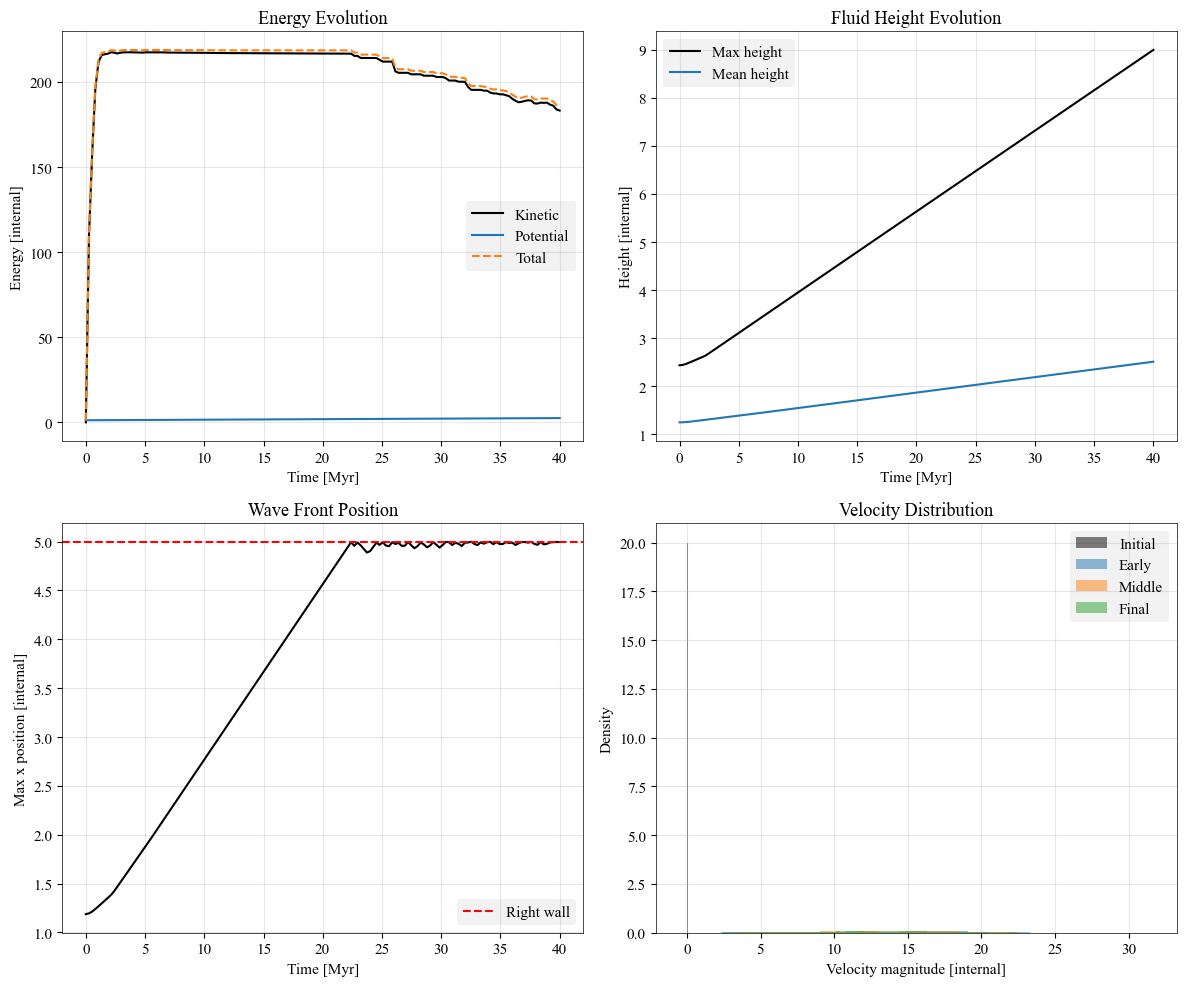

In [ ]:
# ============== ANALYSIS ==============
# Track wave dynamics

# Kinetic energy (per unit depth)
v_squared = np.sum(velocities_out**2, axis=2)
KE = 0.5 * mass * np.sum(v_squared, axis=1)

# Potential energy (gravitational, per unit depth)
PE = mass * g * np.sum(positions_out[:, :, 1], axis=1)

# Total energy
E_total = KE + PE

# Height of fluid (max y position)
max_height = np.max(positions_out[:, :, 1], axis=1)
mean_height = np.mean(positions_out[:, :, 1], axis=1)

# Horizontal spread (max x position of fluid)
max_x = np.max(positions_out[:, :, 0], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Energy
axes[0, 0].plot(times_out, KE, label='Kinetic')
axes[0, 0].plot(times_out, PE, label='Potential')
axes[0, 0].plot(times_out, E_total, label='Total', linestyle='--')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Energy [J/m]')
axes[0, 0].set_title('Energy Evolution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Height
axes[0, 1].plot(times_out, max_height, label='Max height')
axes[0, 1].plot(times_out, mean_height, label='Mean height')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel('Height [m]')
axes[0, 1].set_title('Fluid Height Evolution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Horizontal spread
axes[1, 0].plot(times_out, max_x)
axes[1, 0].axhline(y=tank_length, color='r', linestyle='--', label='Right wall')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Max x position [m]')
axes[1, 0].set_title('Wave Front Position')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Velocity distribution at different times
n_frames = len(times_out)
for idx, label in zip([0, n_frames//3, 2*n_frames//3, n_frames-1], 
                      ['Initial', 'Early', 'Middle', 'Final']):
    v_mag = np.sqrt(np.sum(velocities_out[idx]**2, axis=1))
    axes[1, 1].hist(v_mag, bins=20, alpha=0.5, label=label, density=True)

axes[1, 1].set_xlabel('Velocity magnitude [m/s]')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Velocity Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This simulation demonstrates:

1. **Gravity-driven flow**: The fluid column falls under gravitational acceleration
2. **Wave formation**: As the fluid hits the bottom and spreads, it creates waves
3. **Wave reflection**: Waves bounce off the walls and interact
4. **Energy transfer**: Potential energy converts to kinetic energy during the fall

### Key Observations:
- **Initial collapse**: The dam falls rapidly, converting gravitational PE to KE
- **Wave propagation**: A surge travels across the tank floor
- **Wall reflection**: The wave bounces off the right wall and travels back
- **Energy dissipation**: Some energy is lost at boundaries (damping)

This is a more realistic dam break than the pure pressure case, as real fluids are affected by gravity!